In [1]:
import os
import sys 

import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import tensorflow as tf
from skimage import io
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

from data_generator_3d import *
from model import *
from plotting_helpers import plot_auc

print(tf.__version__)

1.14.0


In [2]:
image_generator = ImageDataGenerator(
#     rotation_range=5,
    rescale=1./255,
#     shear_range=.1, 
#     zoom_range=.05,
#     brightness_range=[.85, 1.0],
#     zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=5,
    width_shift_range=5,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator = ImageDataGenerator(
    validation_split=0.0
)

train_generator = generator(
    base_directory='data/nlst_train/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
)

val_generator = generator(
    base_directory='data/nlst_val/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
)

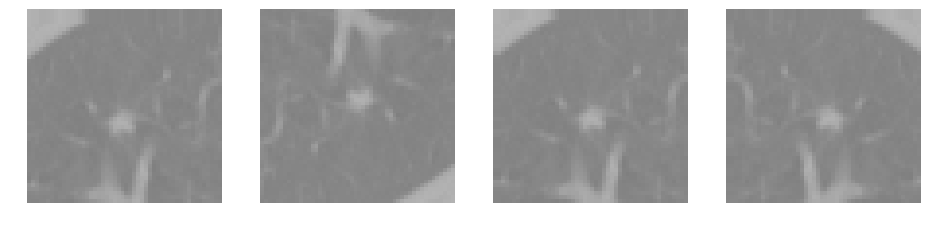

In [3]:
show_augmentation('data/nlst_train/image_roi_3d/25/0.tif', image_generator, n_rows=1)

In [4]:
model = CNN_3D(input_shape=(50, 50, 50, 1))

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 5e-5),
    loss=weighted_cross_entropy,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 50, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 48, 48, 48, 32)    896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 48, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 46, 46, 46, 64)    55360     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 46, 46, 46, 64)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 15, 15, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 13, 13, 13, 128)   221312

In [6]:
model_history = model.fit_generator(
    train_generator,
    validation_data= val_generator,
    validation_steps=200,
    steps_per_epoch=1000,
    epochs = 12
)

Epoch 1/12
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found 623 images belonging to 1 classes.
Found

In [7]:
model.save('nlst_cnn.hdf5') 

In [8]:
# model.load_weights('nlst_cnn_curbest.hdf5')
model.load_weights('nlst_cnn.hdf5')

In [9]:
with open('data/nlst_test/image_roi_3d/patient_lookup.pkl', 'rb') as input_file:
    PatientLookup = pkl.load(input_file)

Patient_Xs = {}
Patient_Ys = {}

Xs = []
Ys = []
for im in os.listdir('data/nlst_test/image_roi_3d/pkls/'):
    path = f'data/nlst_test/image_roi_3d/pkls/{im}'
    with open(path, 'rb') as input_file:
        cube, label = pkl.load(input_file)
    cube = cube[:50][:50][:50]
    if cube.shape[0] < 50 or cube.shape[1] < 50 or cube.shape[2] < 50:
        pass
    else:
        pid = PatientLookup[int(im[:-4])]
        if Patient_Xs.get(pid):
            Patient_Xs[pid].append(np.array(cube/255).reshape(50, 50, 50, 1))
        else:
            Patient_Xs[pid] = [np.array(cube/255).reshape(50, 50, 50, 1)]
        Patient_Ys[pid] = label
        Xs.append(np.array(cube/255).reshape(50, 50, 50, 1))
        Ys.append(label)

0.735632183908046
0.6153846153846154


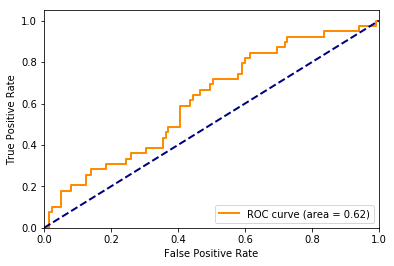

In [10]:
Xs = np.array(Xs)
Ys = np.array(Ys)
preds = np.concatenate([model.predict(Xs[i*5:(i+1)*5]) for i in range(35)])
print(accuracy_score(Ys, np.round(preds)))
print(roc_auc_score(Ys, preds))

fig, ax = plt.subplots(1, 1)
plot_auc(Ys, preds, ax)

Patient accuracy (using mean score):    0.703125
Patient accuracy (using highest value): 0.6875

Patient AUC (using mean score):    0.6352657004830917
Patient AUC (using highest value): 0.6582125603864734


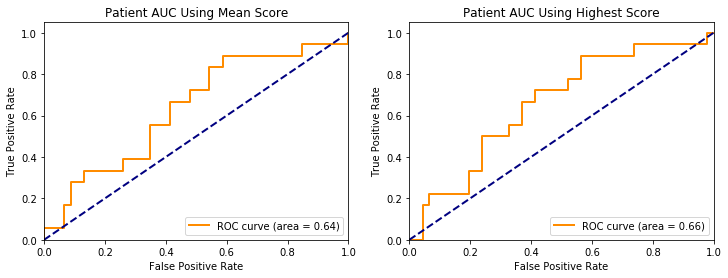

In [16]:
patient_preds_mean = []
patient_preds_greatest = []

for pid, Xs in Patient_Xs.items():
    preds = model.predict(np.array(Xs))
    patient_preds_mean.append(preds.mean())
    preds = sorted(preds, key=lambda x: abs(x-.5), reverse=True)
    patient_preds_greatest.append(np.array(preds[:1]).mean())
    
print("Patient accuracy (using mean score):    " + str(accuracy_score(list(Patient_Ys.values()), np.round(patient_preds_mean))))
print("Patient accuracy (using highest value): " + str(accuracy_score(list(Patient_Ys.values()), np.round(patient_preds_greatest))))

print("\nPatient AUC (using mean score):    " + str(roc_auc_score(list(Patient_Ys.values()), patient_preds_mean)))
print("Patient AUC (using highest value): " + str(roc_auc_score(list(Patient_Ys.values()), patient_preds_greatest)))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_auc(list(Patient_Ys.values()), patient_preds_mean, axs[0])
plot_auc(list(Patient_Ys.values()), patient_preds_greatest, axs[1])

axs[0].set_title("Patient AUC Using Mean Score")
axs[1].set_title("Patient AUC Using Highest Score")

plt.show()